# 第5部 状態空間モデルとカルマンフィルタ

## パッケージインポート

In [2]:
import datetime
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import statsmodels.graphics.api as smg
import statsmodels.tsa.api as tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# from pydataset import data
from rdatasets import data
from scipy.stats import norm
from scipy.optimize import minimize

%matplotlib inline
# sns.set(font="DejaVu Sans") #seabornを日本語対応

## 第5部-7章 実装：Pythonによる状態空間モデル

In [3]:
# データの準備
df = data('Nile')
df['time'] = pd.to_datetime(df['time'], format='%Y')
df = df.set_index('time')
df

,value
time,
1871-01-01,1120
1872-01-01,1160
1873-01-01,963
1874-01-01,1210
1875-01-01,1160
...,...
1966-01-01,746
1967-01-01,919
1968-01-01,718


In [4]:
class KfLocalLevel:
    def __init__(self, y, mu_pre, P_pre, sigma_w, sigma_v):
        self.y = y
        self.mu_pre = mu_pre
        self.P_pre = P_pre
        self.sigma_w = sigma_w
        self.sigma_v = sigma_v

    def predict(self):
        self.mu_forecast = self.mu_pre
        self.P_forecast = self.P_pre + self.sigma_w
        self.y_forecast = self.mu_forecast
        self.F = self.P_forecast + self.sigma_v

    def filtering(self):
        self.K = self.P_forecast / (self.P_forecast + self.sigma_v)
        self.y_resid = self.y - self.y_forecast
        self.mu_filter = self.mu_forecast + self.K * self.y_resid
        self.P_filter = (1 - self.K) * self.P_forecast
    
    def get_result(self):
        result = {'mu_filter': self.mu_filter, 
            'P_filter': self.P_filter, 
            'y_resid': self.y_resid, 
            'F': self.F, 
            'K': self.K}
        return result
    
       



In [5]:
# サンプルサイズ
N = len(df)


# 状態の推定値
mu_filter = np.zeros(N)
mu_zero = 0
mu_filter = np.insert(mu_filter, 0, mu_zero)

# 状態の予測誤差の分散
P_filter = np.zeros(N)
P_zero = 10000000
P_filter = np.insert(P_filter, 0, P_zero)

# 観測値の予測残差
y_resid = np.zeros(N)

# 観測値の予測誤差の分散
F = np.zeros(N)

# カルマンゲイン
K = np.zeros(N)

# 過程誤差の分散
sigma_w = 1000

# 観測誤差の分散
sigma_v = 10000


In [6]:
# Pythonで実装するカルマンフィルタ：状態を推定する
for i in range(0,N):
    # print()
    mdl = KfLocalLevel(y=df.iloc[i, 0], mu_pre=mu_filter[i], P_pre=P_filter[i], sigma_w=sigma_w, sigma_v=sigma_v)
    mdl.predict()
    mdl.filtering()
    kekka = mdl.get_result()

    mu_filter[i+1] = kekka['mu_filter']
    P_filter[i+1] = kekka['P_filter']
    y_resid[i] = kekka['y_resid']
    F[i] = kekka['F']
    K[i] = kekka['K']


In [7]:
kekka

{'mu_filter': 797.3906168003781,
 'P_filter': 2701.5621187164243,
 'y_resid': -78.63411011218307,
 'F': 13701.562118716425,
 'K': 0.2701562118716424}

In [8]:
#  Pythonで実装するカルマンフィルタ：対数尤度
sum(np.log(norm.pdf(y_resid, loc=0, scale=np.sqrt(F))))

-646.3254194111224

In [9]:
#  Pythonで実装するカルマンフィルタ：最尤法
def calkLogLik(sigma):
    sigma_w = np.exp(sigma[0])
    sigma_v = np.exp(sigma[1])

    N = len(df)
    mu_filter = np.zeros(N)
    mu_zero = 0
    mu_filter = np.insert(mu_filter, 0, mu_zero)
    P_filter = np.zeros(N)
    P_zero = 10000000
    P_filter = np.insert(P_filter, 0, P_zero)
    y_resid = np.zeros(N)
    F = np.zeros(N)
    K = np.zeros(N)

    for i in range(0,N):
        mdl = KfLocalLevel(y=df.iloc[i, 0], mu_pre=mu_filter[i], P_pre=P_filter[i], sigma_w=sigma_w, sigma_v=sigma_v)
        mdl.predict()
        mdl.filtering()
        kekka = mdl.get_result()

        mu_filter[i+1] = kekka['mu_filter']
        P_filter[i+1] = kekka['P_filter']
        y_resid[i] = kekka['y_resid']
        F[i] = kekka['F']
        K[i] = kekka['K']
        # print(kekka)

    
    # print(kekka)
    # return sum(np.log(norm.pdf(y_resid, loc=0, scale=np.sqrt(F))))
    return 1/2 * sum(np.log(F) + y_resid ** 2 / F)


In [10]:
best_sigma = minimize(calkLogLik, np.array([1,1]), method='L-BFGS-B')
np.exp(best_sigma.x)

array([ 1468.424039  , 15099.81072079])

In [15]:
# Pythonで実装する平準化
def smoothLocalLevel(mu_filtered, P_filtered, r_post, s_post, F_post, y_resid_post, K_post):
    # 状態平滑化漸化式
    r = y_resid_post / F_post + (1 - K_post) * r_post
    mu_smooth = mu_filtered + P_filtered * r

    # 状態分散平滑化漸化式
    s = 1/F_post + (1 - K_post) ** 2 * s_post
    P_smooth = P_filtered - P_filtered ** 2 * s

    # 結果の格納
    result = {'mu_smooth': mu_smooth, 
            'P_smooth': P_smooth, 
            'y_resid': y_resid, 
            'r': r, 
            's': s}

    return result

In [12]:
# 平滑化状態
mu_smooth = np.zeros(N+1)
# 平滑化状態分散
P_smooth = np.zeros(N+1)
# 漸化式パラメタ
r = np.zeros(N)
s = np.zeros(N)

# 最後のデータは、フィルタリングの結果とスムージングの結果が一致する
mu_smooth[N] = mu_filter[N]
P_smooth[N] = P_filter[N]

In [16]:
for i in reversed(range(0, N)):
    kekka = smoothLocalLevel(mu_filter[i], P_filter[i], r[i], s[i], F[i], y_resid[i], K[i])

    mu_smooth[i] = kekka['mu_smooth']
    P_smooth[i] = kekka['P_smooth']
    r[i-1] = kekka['r']
    s[i-1] = kekka['s']

In [26]:
df

,value
time,
1871-01-01,1120
1872-01-01,1160
1873-01-01,963
1874-01-01,1210
1875-01-01,1160
...,...
1966-01-01,746
1967-01-01,919
1968-01-01,718


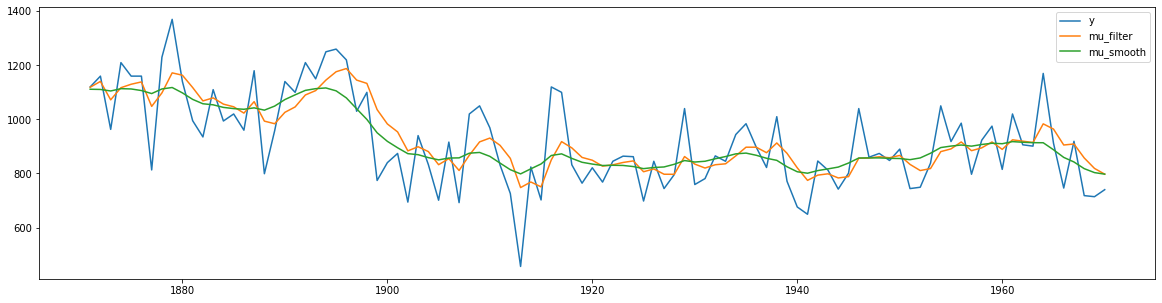

In [44]:
f, ax= plt.subplots(figsize=(20,5))

ax.plot(df['value'], label='y')
ax.plot(pd.Series(mu_filter[1:], index=df.index), label='mu_filter') #フィルタ化推定量
ax.plot(pd.Series(mu_smooth[1:], index=df.index), label='mu_smooth') #平準化状態
# pd.Series(mu_smooth).plot()
ax.legend()

C:\Users\sk0ea\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


log likelihood: -632.5377605722427


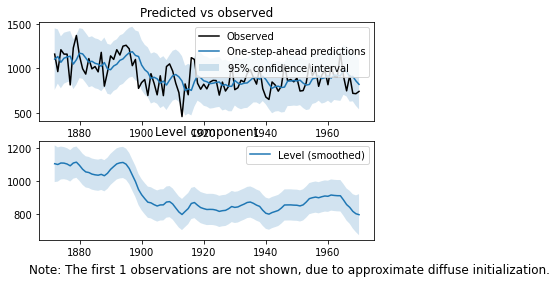

In [75]:
# statsmodelsによるカルマンフィルタ
mod_uc = tsa.UnobservedComponents(df['value'], level='local level', start_params=[sigma_w, sigma_v])
res_uc = mod_uc.fit()

# plot
res_uc.plot_components();

# filtered value
# res_uc.level['filtered']

# log likelihood
print(f'log likelihood: {res_uc.llf}')

## 第5部-8章 実装：KFAS(Statsmodels)の使い方

In [94]:
nile_train = df[:'1950-01-01'].copy()
nile_train.loc['1910':'1920', 'value'] = np.nan

C:\Users\sk0ea\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


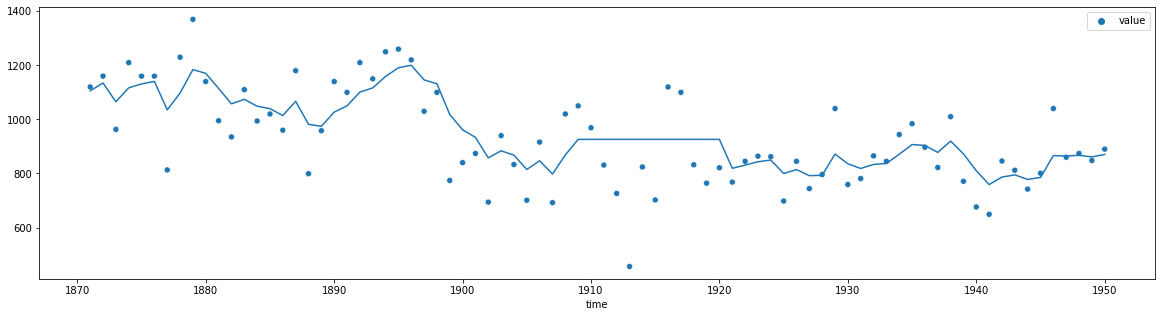

In [95]:
mod_uc = tsa.UnobservedComponents(nile_train, level='local level', start_params=[sigma_w, sigma_v])
res_uc = mod_uc.fit()

mu_filtered = pd.Series(res_uc.level['filtered'], index=nile_train.index)
y = df[:'1950-01-01']

f, ax= plt.subplots(figsize=(20,5))

ax = sns.scatterplot(data=y)
ax = sns.lineplot(data=mu_filtered)

In [106]:
# 予測
res_uc.forecast(20)

1951-01-01    870.322778
1952-01-01    870.322778
1953-01-01    870.322778
1954-01-01    870.322778
1955-01-01    870.322778
1956-01-01    870.322778
1957-01-01    870.322778
1958-01-01    870.322778
1959-01-01    870.322778
1960-01-01    870.322778
1961-01-01    870.322778
1962-01-01    870.322778
1963-01-01    870.322778
1964-01-01    870.322778
1965-01-01    870.322778
1966-01-01    870.322778
1967-01-01    870.322778
1968-01-01    870.322778
1969-01-01    870.322778
1970-01-01    870.322778
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [151]:
# 実装：変化するトレンドのモデル化
n_sample = 450
t0 = 0.2 # 変化しないトレンド
constant_trend = [0.2] * 450
constant_trend = np.cumsum(constant_trend)
constant_trend

trend = [0.2] * 100 + [0.4] * 100 + [0] * 100 + [-0.2] * 150
change_trend = np.cumsum(trend) 

Text(0.5, 1.0, 'change_trend')

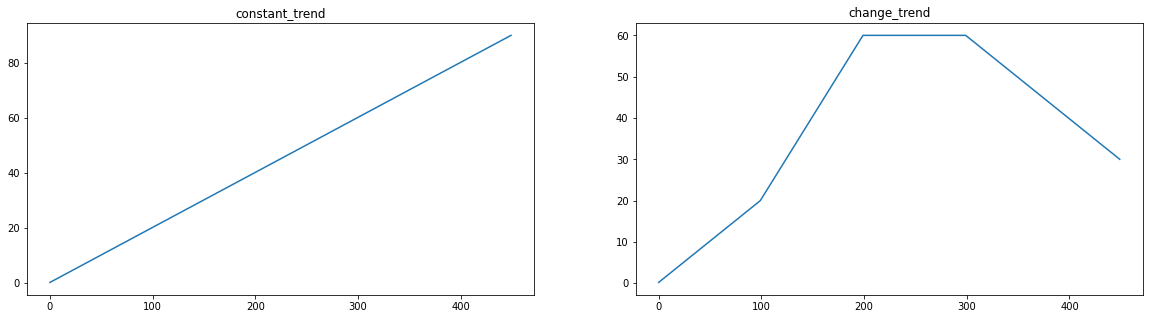

In [152]:
f, ax= plt.subplots(1,2,figsize=(20,5))

ax[0].plot(constant_trend)
ax[1].plot(change_trend)
ax[0].set_title("constant_trend")
ax[1].set_title("change_trend")

In [211]:
# 水準の過程誤差
system_noise = np.random.normal(size=n_sample)

# 真の水準値
alpha_true = np.zeros(n_sample+1)

for i in range(n_sample):
    alpha_true[i+1] = alpha_true[i] + trend[i] + system_noise[i]

# 観測誤差
obs_noise = np.random.normal(size=n_sample, loc=0, scale=np.sqrt(5))
sales = alpha_true[:450] + obs_noise + 11

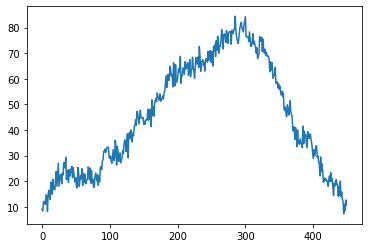

In [212]:
plt.plot(sales)

In [213]:
sales_train = sales[:400].copy()
sales_train[124:174] = np.nan
sales_test = sales[400:]

In [214]:
mod_uc = tsa.UnobservedComponents(sales_train, level='local linear trend', start_params=[sigma_w, sigma_v])
res_uc = mod_uc.fit()
params_uc = dict(zip(res_uc.param_names, res_uc.params))
# for i in res_uc.level.keys():
#     print(i)

res_uc.trend

{'filtered': array([ 0.00000000e+00, -7.73173403e-01,  1.31330211e+00,  1.24149963e+00,
         7.99170982e-01,  5.03831731e-01,  7.80237118e-01,  7.48468641e-01,
         2.51101471e-01,  4.41692564e-01,  5.88414600e-01,  5.21864189e-01,
         4.09165517e-01,  5.97521753e-01,  6.69390153e-01,  5.40475020e-01,
         6.25154402e-01,  5.71452156e-01,  4.99277943e-01,  4.46519018e-01,
         5.06741345e-01,  5.95268244e-01,  5.07236907e-01,  5.44042402e-01,
         6.41598871e-01,  5.11304196e-01,  4.63842442e-01,  4.69311302e-01,
         4.63767692e-01,  3.90068866e-01,  4.10241348e-01,  4.03288858e-01,
         4.73939333e-01,  5.08415562e-01,  4.88340120e-01,  5.35192938e-01,
         4.17482866e-01,  3.87630882e-01,  3.71631944e-01,  2.83989294e-01,
         3.00076277e-01,  2.67326173e-01,  2.58312787e-01,  2.79300211e-01,
         2.98744648e-01,  2.41582030e-01,  2.59069339e-01,  2.30828938e-01,
         1.89428468e-01,  1.36684115e-01,  1.25299047e-01,  6.06765250e-02,


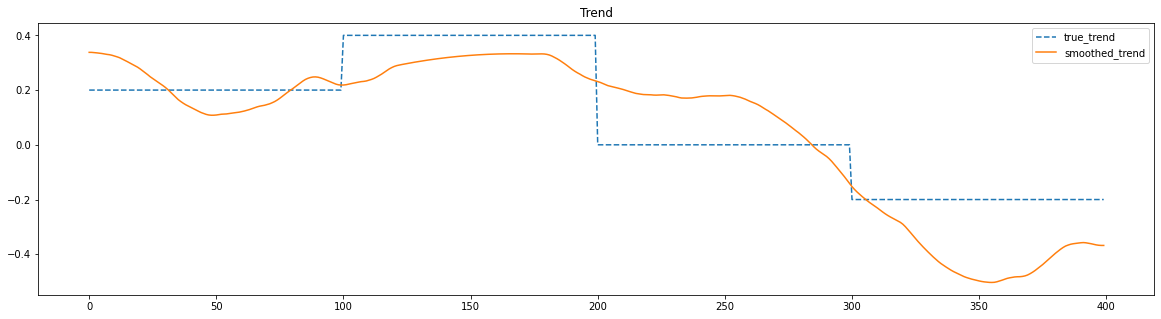

In [215]:
# トレンドの図示
f, ax= plt.subplots(figsize=(20,5))

ax.plot(trend[:400], linestyle="dashed", label='true_trend')
ax.plot(res_uc.trend.smoothed, label='smoothed_trend')
ax.legend()
ax.set_title("Trend");
# ax[1].plot(change_trend)

In [249]:
# 補間と予測結果
estimate_all = res_uc.get_prediction(0, 450).summary_frame()
estimate_all.iloc[0:2, 2:4] = 0
estimate_all
# res_uc.forecast(50)

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,0.000000,1000.002612,0.000000,0.000000
1,9.072102,1000.005700,0.000000,0.000000
2,7.525751,5.766312,-3.776013,18.827514
3,12.356155,4.346641,3.836896,20.875414
4,13.425530,3.805101,5.967670,20.883390
...,...,...,...,...
446,16.688446,14.133146,-11.012011,44.388903
447,16.320696,14.424487,-11.950779,44.592170
448,15.952945,14.717702,-12.893221,44.799111
449,15.585195,15.012782,-13.839318,45.009707


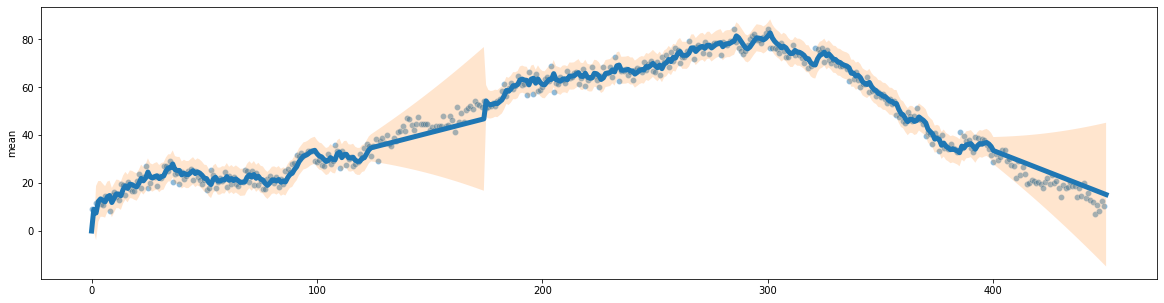

In [252]:
# 補間と予測結果の図示
f, ax= plt.subplots(figsize=(20,5))

ax = sns.scatterplot(data=sales, alpha=0.5)
ax = sns.lineplot(data=estimate_all['mean'], lw=5)
ax = plt.fill_between(x=estimate_all.index, y1=estimate_all['mean_ci_upper'], y2=estimate_all['mean_ci_lower'], alpha=0.2)

In [254]:
#ARIMAによる予測結果との比較
sales_train = sales[:400].copy()
auto_arima = pm.auto_arima(
                    y=sales_train, 
                    # X=train[['PetrolPrice', 'law']], 
#                   stepwise=False, 
                    # seasonal=True,
                    max_order = 5,
                    # m = 12,
                    approximation = False,
                    information_criterion='aic')
auto_arima

ARIMA(order=(3, 2, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

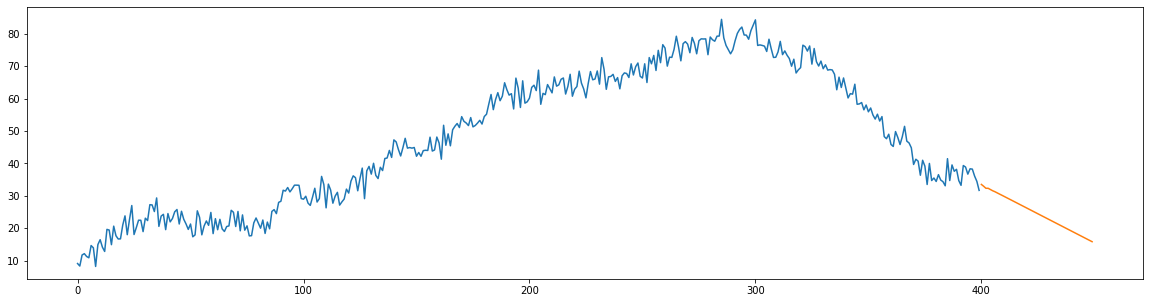

In [269]:
forcast_arima = auto_arima.predict(len(sales_test))

f, ax= plt.subplots(figsize=(20,5))

ax.plot(np.arange(0,400), sales_train)
ax.plot(np.arange(400,450), forcast_arima)

## 第5部-10章 応用：広告の効果はどれだけ持続するか

In [316]:
n_sample = 450

# 時間によって変化する広告効果
true_reg_coef = [-np.log(x) ** 2 + 8 for x in range(1,51)]
# ランダムウォークする水準値
mu = np.cumsum(np.random.normal(size=n_sample, loc=0, scale=0.5)) + 15
# 状態（水準値＋広告効果）
x = [0.0]*200 + true_reg_coef + [0.0]*200
x = x + mu

# 観測誤差
obs_error = np.random.normal(size=n_sample, loc=0, scale=2)
# 広告効果が入った売上データ
sales_ad = x + obs_error

# 説明変数
ad_flg = [1 if 200 <= i < 250 else 0 for i in range(450)]

df = pd.DataFrame(zip(sales_ad, ad_flg), columns=['sales_ad', 'ad_flg'])
df

,sales_ad,ad_flg
0,12.501833,0
1,14.595716,0
2,13.640707,0
3,16.380399,0
4,16.252070,0
...,...,...
445,14.834036,0
446,13.708227,0
447,12.170634,0
448,11.265224,0


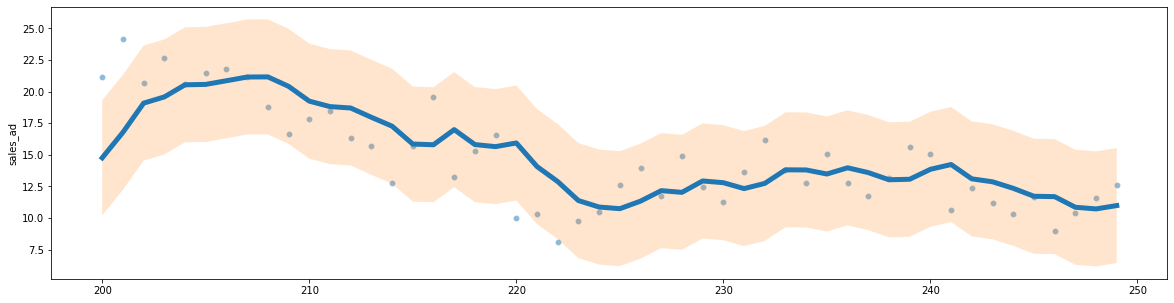

In [329]:
# Statsmodelsによる時変係数モデル
mod_uc = tsa.UnobservedComponents(df['sales_ad'], level='local level', exog=df['ad_flg'])
res_uc = mod_uc.fit()
estimate_all = res_uc.get_prediction(0, 449).summary_frame()[200:250]
# estimate_all
f, ax= plt.subplots(figsize=(20,5))

ax = sns.scatterplot(data=df['sales_ad'][200:250], alpha=0.5)
ax = sns.lineplot(data=estimate_all['mean'], lw=5)
ax = plt.fill_between(x=estimate_all.index, y1=estimate_all['mean_ci_upper'], y2=estimate_all['mean_ci_lower'], alpha=0.2)